# Simulation 


### 0. Setup

In [1]:
# Setup ---------------------------------------------------------------

set.seed(1)
library(tidyverse)


── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.1     ✔ stringr   1.5.2
✔ ggplot2   4.0.0     ✔ tibble    3.3.0
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.1.0     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


We create several populations to sample from, and helper functions to build sampling and bootstrap distributions.

In [ ]:
# Populations ---------------------------------------------------------

# We can define population using RNG functions from R
#     write your own functions (based on the pdf definitions) if needed
#     or generate a large sample to approximate the population. 

r_normal   <- function(n) rnorm(n, mean = 50, sd = 10)
r_skewed   <- function(n) rexp(n, rate = 1)                 # mean 1, sd 1
r_discrete <- function(n) rbinom(n, size = 1, prob = 0.3)
r_t2       <- function(n) rt(n, df = 2)
r_t3       <- function(n) rt(n, df = 3)

# Useful population SDs (for theoretical SE calculations)
sd_normal   <- 10
sd_skewed   <- 1
sd_discrete <- sqrt(0.3 * 0.7)
# Note: t(2) has infinite variance, so its SD is not finite.
sd_t2 <- Inf
sd_t3 <- sqrt(3)  # Var(t_df) = df/(df-2) for df > 2


In [ ]:
# It may be helpful to write functions that will be called repeatedly



sampling_distribution <- function(rfun, n, reps = 5000) {
  means <- numeric(reps)
  for (i in seq_len(reps)) {
    s <- rfun(n)
    means[i] <- mean(s)
  }
  means
}


sampling_distribution_stat <- function(rfun, n, reps, stat_fun) {
  out <- numeric(reps)
  for (i in seq_len(reps)) {
    s <- rfun(n)
    out[i] <- stat_fun(s)
  }
  out
}


bootstrap_distribution <- function(sample_vec, B = 3000, stat_fun = mean) {
  n <- length(sample_vec)
  out <- numeric(B)
  for (b in seq_len(B)) {
    s <- sample(sample_vec, size = n, replace = TRUE)
    out[b] <- stat_fun(s)
  }
  out
}


### 1. Sampling Distribution of the Mean (Central Limit Theorem)

Consider the skewed population `pop_skewed`. For sample sizes $n = 5, 30, 200$, simulate the sampling distribution of the sample mean $\bar{X}$. Plot the resulting distributions.


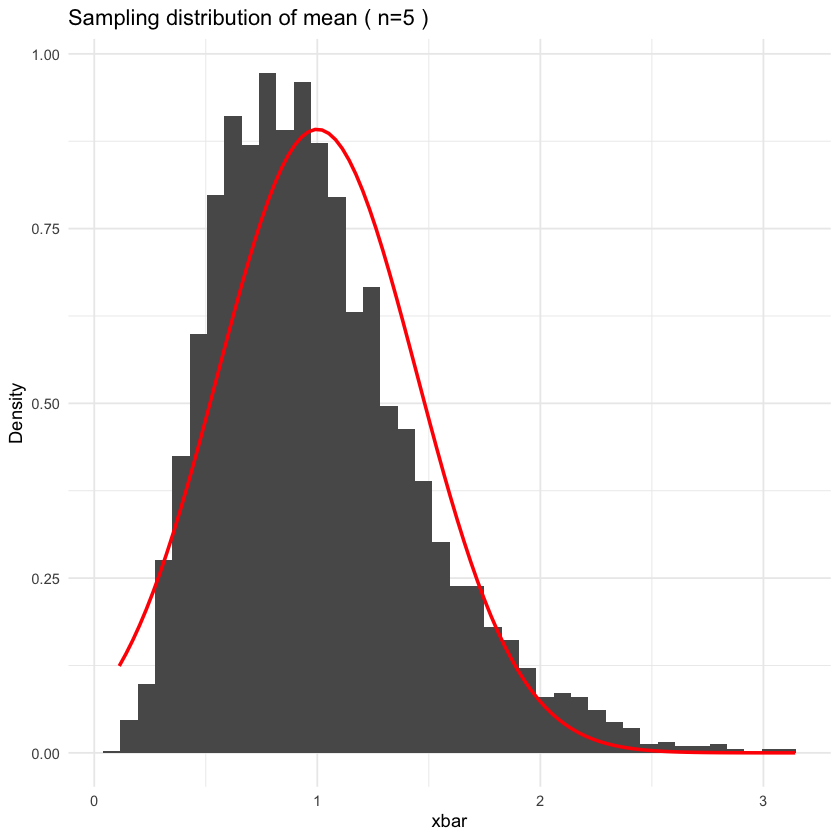

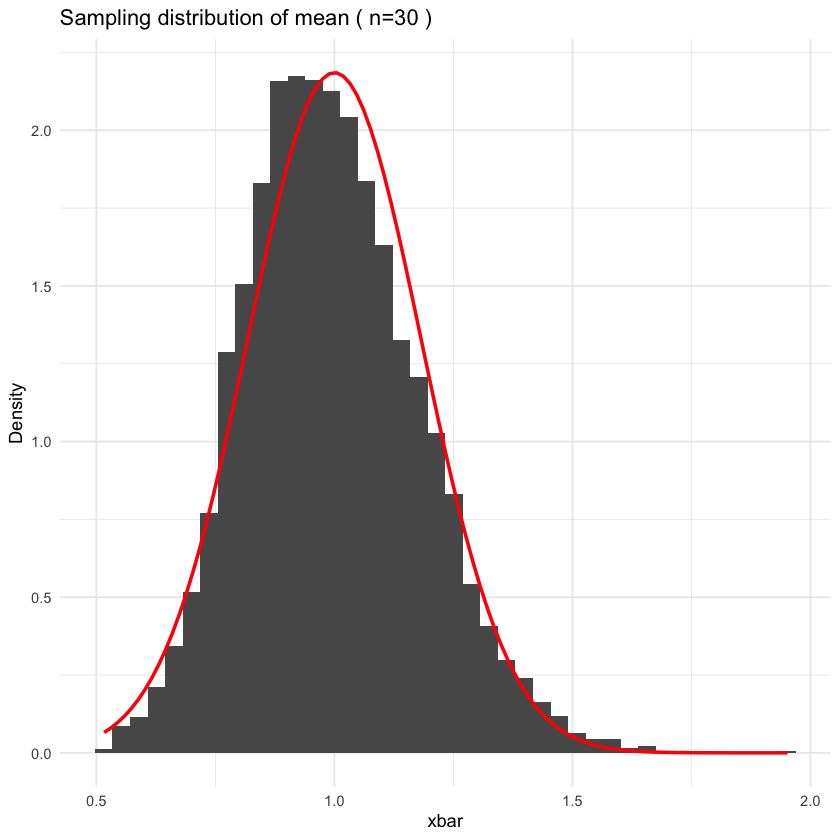

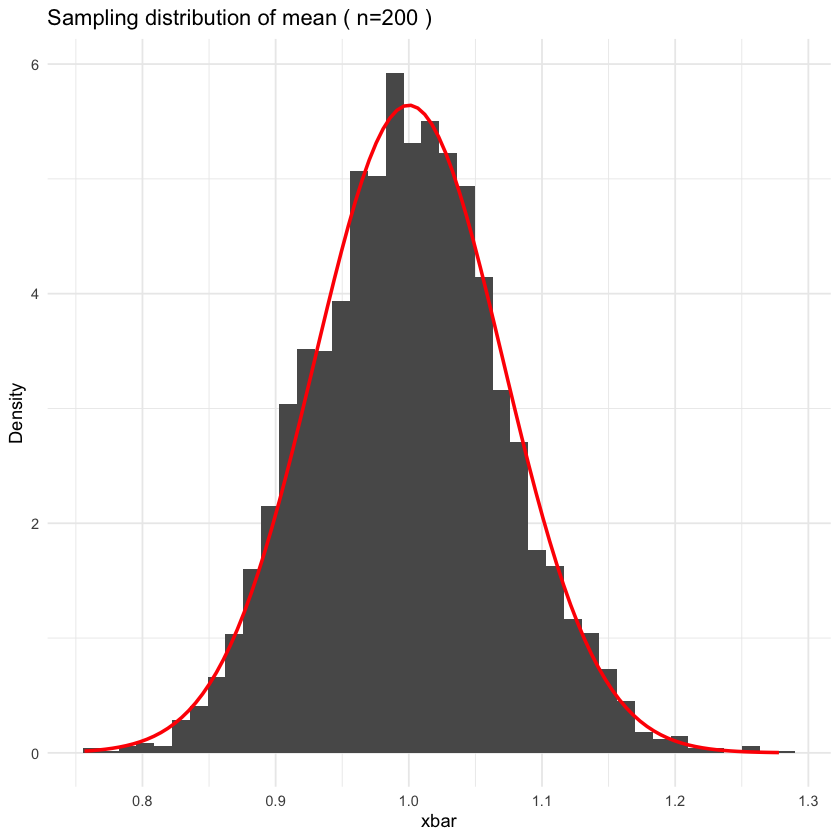

In [ ]:
rfun <- r_skewed
pop_sd <- sd_skewed     # for Exp(1), this should be 1
pop_mean <- 1           # for Exp(1)
# (optional) sanity check:
# pop_sd <- 1; pop_mean <- 1

sizes <- c(5, 30, 200)
results_mean <- lapply(sizes, function(n) sampling_distribution(rfun, n))
names(results_mean) <- paste0("n=", sizes)

for (name in names(results_mean)) {
  dist <- results_mean[[name]]
  n <- as.numeric(sub("n=", "", name))
  
  df <- tibble(x = dist)
  
  # CLT approximation: xbar ~ N(pop_mean, pop_sd^2 / n)
  mu_clt <- pop_mean
  sd_clt <- pop_sd / sqrt(n)
  
  g <- ggplot(df, aes(x = x)) +
       +
    stat_function(
      fun = dnorm,
      args = list(mean = mu_clt, sd = sd_clt),
      linewidth = 1,
      color = "red"
    ) +
    labs(
      title = paste("Sampling distribution of mean (", name, ")"),
      x = "xbar",
      y = "Density"
    ) +
    theme_minimal()
  
  print(g)
}


### 2. Empirical vs Theoretical Standard Error

For each sampling distribution above, compute the empirical standard deviation of the sample means and compare it to the theoretical standard error $\sigma / \sqrt{n}$, where $\sigma$ is the population standard deviation of `pop_skewed`.

In [9]:

pop_sd <- sd_skewed

for (i in seq_along(sizes)) {
  n <- sizes[i]
  dist <- results_mean[[i]]
  empirical <- sd(dist)
  theo <- pop_sd / sqrt(n)
  cat("n =", n, ": empirical SE =", round(empirical, 4),
      ", theoretical SE =", round(theo, 4), "\n")
}


n = 5 : empirical SE = 0.4444 , theoretical SE = 0.4472 
n = 30 : empirical SE = 0.1825 , theoretical SE = 0.1826 
n = 200 : empirical SE = 0.0715 , theoretical SE = 0.0707 


### 3. Monte Carlo Estimation of a Probability

Let $X$ be drawn from the skewed population `pop_skewed`. Estimate
$P(\bar{X} > 1)$ using Monte Carlo simulation for sample sizes $n = 5$ and $n = 30$.

In [8]:

mc_prob <- function(rfun, n, reps = 20000, threshold = 1) {
  count <- 0
  for (i in seq_len(reps)) {
    xbar <- mean(rfun(n))
    if (xbar > threshold) count <- count + 1
  }
  count / reps
}

for (n in c(5, 30)) {
  cat("n =", n, ": P(xbar > 1) ≈", mc_prob(rfun, n), "\n")
}


n = 5 : P(xbar > 1) ≈ 0.4406 
n = 30 : P(xbar > 1) ≈ 0.4756 


### 4. Bootstrap Distribution of the Sample Mean

Take a single sample of size $n = 50$ from `pop_skewed`. Use bootstrap resampling to approximate the sampling distribution of the sample mean. Compare the bootstrap distribution to the Monte Carlo sampling distribution obtained from the known population.

Warning message:
“Multiple drawing groups in `geom_function()`
ℹ Did you use the correct group, colour, or fill aesthetics?”


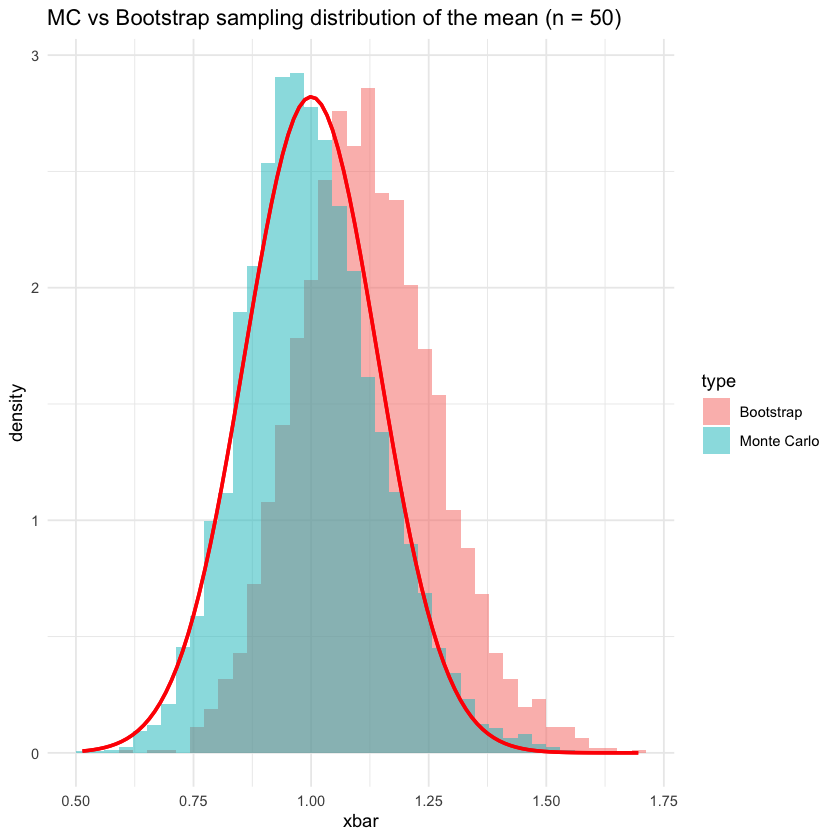

In [16]:

set.seed(2)
rfun <- r_skewed
sample_50 <- rfun(50)

boot_means <- bootstrap_distribution(sample_50, B = 3000, stat_fun = mean)
mc_means   <- sampling_distribution(rfun, n = 50)

df_boot <- tibble(x = boot_means, type = "Bootstrap")
df_mc   <- tibble(x = mc_means,   type = "Monte Carlo")
df_all  <- bind_rows(df_boot, df_mc)

mu_clt <- 1
sd_clt <- 1 / sqrt(50)

g <- ggplot(df_all, aes(x = x, fill = type)) +
  geom_histogram(aes(y = after_stat(density)), bins = 40, alpha = 0.5, position = "identity") +
  stat_function(
      fun = dnorm,
      args = list(mean = mu_clt, sd = sd_clt),
      linewidth = 1,
      color = "red"
    ) +
  labs(title = "MC vs Bootstrap sampling distribution of the mean (n = 50)", x = "xbar") +
  theme_minimal()
print(g)


### 5. Bootstrap Standard Error

Compute the bootstrap standard error of the sample mean from Problem 4 and compare it with:

- Theoretical standard error $\sigma/\sqrt{50}$
- Empirical Monte Carlo standard error from the distribution of Monte Carlo means.

In [18]:
# Problem 5: Bootstrap SE vs theoretical and MC SE --------------------

bootstrap_se <- sd(boot_means)
theoretical_se <- pop_sd / sqrt(50)
mc_se <- sd(mc_means)

cat("Bootstrap SE:", round(bootstrap_se, 4), "\n")
cat("Theoretical SE:", round(theoretical_se, 4), "\n")
cat("Monte Carlo SE:", round(mc_se, 4), "\n")


Bootstrap SE: 0.1483 
Theoretical SE: 0.1414 
Monte Carlo SE: 0.1441 


# Exercise

### Exercise 1 Sampling Distribution of the $10\%$ quantile

For the skewed population `r_skewed`, compute the sampling distribution of the $10\%$ quantile for sample sizes $n = 10, 30, 200$. Compare the distribution and standard errors to those of the ordinary mean.

In [ ]:
# Exercise 1

# sample_sizes <- c(10, 30, 200)

#quantile_results <- lapply(sample_sizes, function(n) {
#  sampling_distribution_stat(r_skewed, n, reps = 4000,
#                             stat_fun = FILL THE FUNCTION HERE)
# })
# names(quantile_results) <- paste0("n=", sample_sizes)

# mean_results <- lapply(sample_sizes, FILL THE FUNCTION HERE)
# names(mean_results) <- paste0("n=", sample_sizes)

# for (i in seq_along(sample_sizes)) {
#  n <- sample_sizes[i]
#  df_quantile <- tibble(x = quantile_results[[i]], type = "Quantile")
#  df_mean <- tibble(x = mean_results[[i]],    type = "Mean")
#  df_all  <- bind_rows(df_quantile, df_mean)

#  g <- ggplot(df_all, aes(x = x, fill = type)) +
#    geom_histogram(aes(y = after_stat(density)), bins = 40, alpha = 0.5, position = "identity") +
#    labs(title =  , x =  ) +
#    theme_minimal()
#  print(g)
#}

# for (i in seq_along(sample_sizes)) {
#  n <- sample_sizes[i]
#  se_quantile <- sd(quantile_results[[i]])
#  se_mean <- sd(mean_results[[i]])
#  cat("n =", n, ": SE(quantile) =", round(se_quantile, 4),
#      ", SE(mean) =", round(se_mean, 4), "\n")
# }


### Exercise 2 Bootstrap CI for the Median

Draw a sample of size $n = 80$ from `r_skewed`. Use bootstrap resampling to compute a $95\%$ percentile confidence interval for the median. Compare to a Monte Carlo confidence interval based on the known population.

In [2]:
# Exercise 2 

# set.seed(7)
# s80 <- rfun(80)

# boot_meds <-  
# boot_ci <-  

# mc_meds <- 
# mc_ci <- 

#cat("Bootstrap 95% CI for median:\n")
#print(boot_ci)
#cat("Monte Carlo 95% CI for median:\n")
#print(mc_ci)

#df_boot <- tibble(x = boot_meds)
#g <- ggplot(df_boot, aes(x = x)) +
#  geom_histogram(aes(y = after_stat(density)), bins = 40) +
#  labs(title = "Bootstrap distribution of the median (n = 80)", x = "median") +
#  theme_minimal()
#print(g)


### Exercise 3 Parametric vs Nonparametric Bootstrap

Using a sample of size $n = 50$ from `r_skewed`:

1. Construct a nonparametric bootstrap distribution of the mean.
2. Fit an exponential model and construct a parametric bootstrap distribution assuming an exponential population.
3. Compare both bootstrap distributions to the Monte Carlo sampling distribution of the mean from the true population.

In [ ]:
# Exercise 3

# set.seed(9)
# s50 <- rfun(50)

# Nonparametric bootstrap
# bs_np <-  

# Parametric bootstrap (exponential model)
# lambda_hat <- 1 / mean(s50)
# bs_param <- replicate(3000, mean(rexp(50, rate = lambda_hat)))

# True Monte Carlo distribution
# mc_true <-  
# df_np    <- tibble(x = bs_np,    type = "Nonparametric BS")
# df_param <- tibble(x = bs_param, type = "Parametric BS")
# df_mc    <- tibble(x = mc_true,  type = "Monte Carlo")
#df_all   <- bind_rows(df_np, df_param, df_mc)

# g <- ggplot(df_all, aes(x = x, fill = type)) +
#  geom_histogram(aes(y = after_stat(density)), bins = 40, alpha = 0.5, position = "identity") +
#  labs(title =  , x =  ) +
#  theme_minimal()
# print(g)


### Exercise 4 Bootstrap for Heavy-Tailed Data

Generate a sample of size $n = 100$ from a heavy-tailed $t(2)$ distribution. Use bootstrap to estimate the sampling distribution of the mean and compare it to the Monte Carlo distribution from the known population.

In [4]:
#  Exercise 4
# set.seed(13)
# rfun <- r_t2  # t(2), heavy tails
# sample_t <- rfun(100)

# bs_t <- 
# mc_t <- 

# df_bs <- tibble(x = bs_t, type = "Bootstrap")
# df_mc <- tibble(x = mc_t, type = "Monte Carlo")
# df_all <- bind_rows(df_bs, df_mc)

# g <- ggplot(df_all, aes(x = x, fill = type)) +
#  geom_histogram(aes(y = after_stat(density)), bins = 40, alpha = 0.5, position = "identity") +
#  labs(title =  , x =  ) +
#  theme_minimal()
# print(g)
